In [8]:
library(tidyverse)
library(cluster)


In [9]:
set.seed(1)

In [10]:
happiness <- read_csv("/home/asus/content/Notes/Semester 4/FDN Lab/Experiments/Experiment 6/archive(11)/2019.csv")



Rows: 156 Columns: 9
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Country
dbl (8): Overall rank, Score, GDP per capita, Social support, Healthy life e...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [11]:
head(happiness)
summary(happiness)


Overall rank,Country,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410
3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341
4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118
5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298
6,Switzerland,7.480,1.452,1.526,1.052,0.572,0.263,0.343


  Overall rank      Country              Score       GDP per capita  
 Min.   :  1.00   Length:156         Min.   :2.853   Min.   :0.0000  
 1st Qu.: 39.75   Class :character   1st Qu.:4.545   1st Qu.:0.6028  
 Median : 78.50   Mode  :character   Median :5.380   Median :0.9600  
 Mean   : 78.50                      Mean   :5.407   Mean   :0.9051  
 3rd Qu.:117.25                      3rd Qu.:6.184   3rd Qu.:1.2325  
 Max.   :156.00                      Max.   :7.769   Max.   :1.6840  
 Social support  Healthy life expectancy Freedom to make life choices
 Min.   :0.000   Min.   :0.0000          Min.   :0.0000              
 1st Qu.:1.056   1st Qu.:0.5477          1st Qu.:0.3080              
 Median :1.272   Median :0.7890          Median :0.4170              
 Mean   :1.209   Mean   :0.7252          Mean   :0.3926              
 3rd Qu.:1.452   3rd Qu.:0.8818          3rd Qu.:0.5072              
 Max.   :1.624   Max.   :1.1410          Max.   :0.6310              
   Generosity     Pe

In [12]:
# Filtering out the text cols
features <- c("Overall rank", "Score", "GDP per capita", "Social support", "Healthy life expectancy", "Freedom to make life choices", "Generosity", "Perceptions of corruption")

happiness <- happiness %>%
  select(all_of(features)) %>%
  na.omit()


In [13]:

features <- c("Overall rank", "Score", "GDP per capita", "Social support", "Healthy life expectancy", "Freedom to make life choices", "Generosity", "Perceptions of corruption")

happiness_country <- happiness %>%
  select(all_of(features))

In [14]:
#SCAAAAAAAAAAAAAAAALIng
happiness_scaled <- scale(happiness)


In [15]:
# total within-cluster sum of squares
wss <- function(k) {
  kmeans(happiness_scaled, k, nstart = 10)$tot.withinss
}



In [16]:
k_values <- 1:10
wss_values <- map_dbl(k_values, wss)


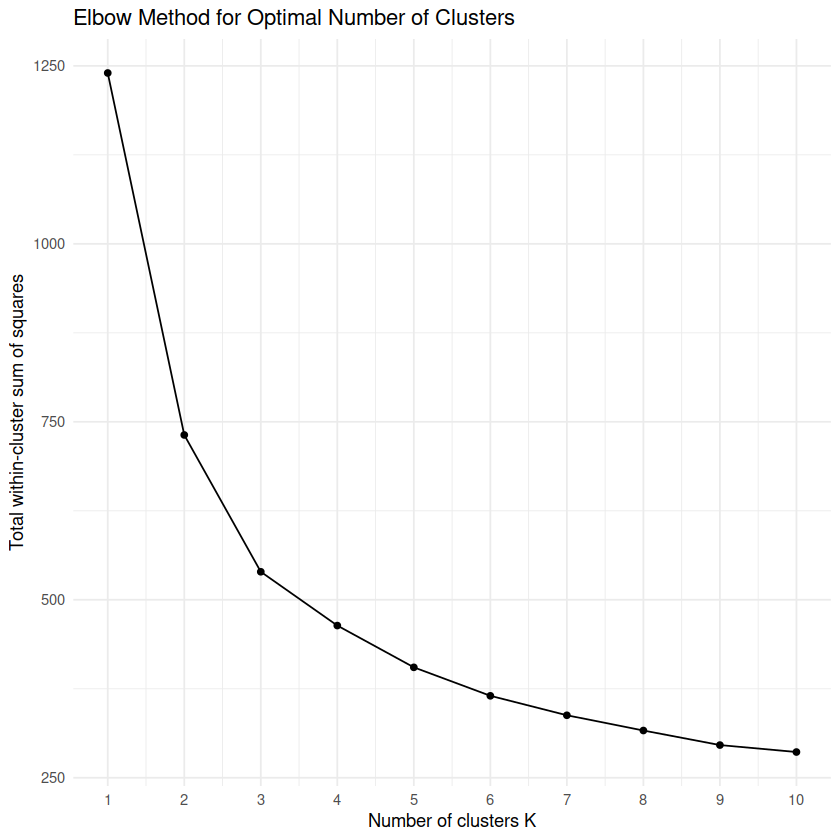

In [17]:
ggplot(data.frame(k = k_values, wss = wss_values), aes(k, wss)) +
  geom_line() + geom_point() +
  scale_x_continuous(breaks = k_values) +
  labs(title = "Elbow Method for Optimal Number of Clusters",
       x = "Number of clusters K",
       y = "Total within-cluster sum of squares") +
  theme_minimal()


In [18]:
avg_sil <- function(k) {
  km.res <- kmeans(happiness_scaled, centers = k, nstart = 25)
  ss <- silhouette(km.res$cluster, dist(happiness_scaled))
  mean(ss[, 3])
}


In [19]:
k_values <- 2:10
avg_sil_values <- map_dbl(k_values, avg_sil)


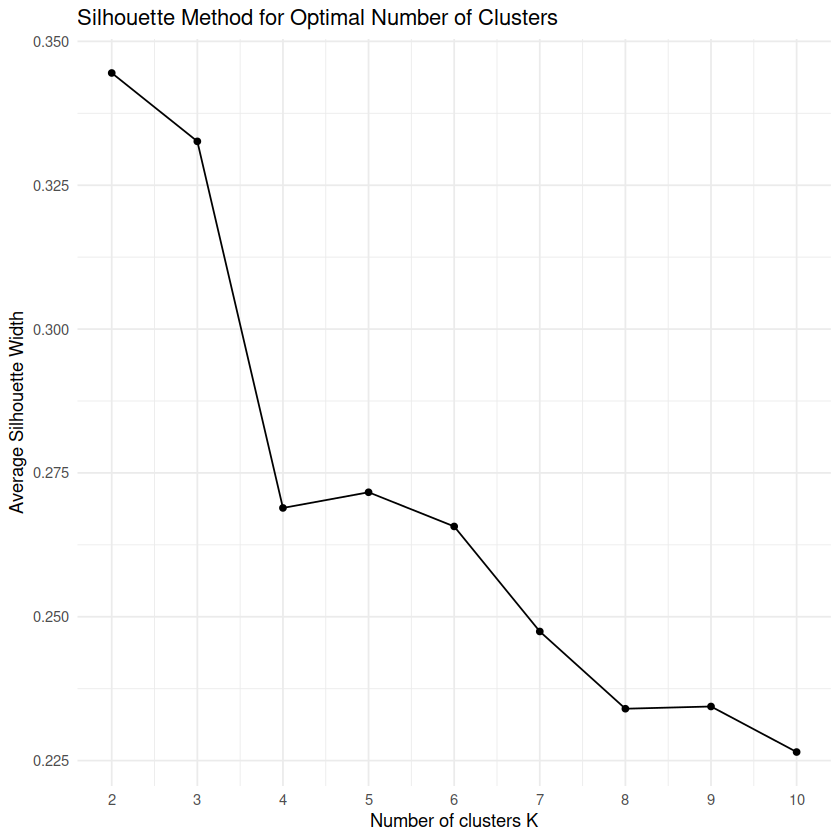

In [20]:

ggplot(data.frame(k = k_values, silhouette = avg_sil_values), aes(k, silhouette)) +
  geom_line() + geom_point() +
  scale_x_continuous(breaks = k_values) +
  labs(title = "Silhouette Method for Optimal Number of Clusters",
       x = "Number of clusters K",
       y = "Average Silhouette Width") +
  theme_minimal()

In [21]:

optimal_k <- 5



In [22]:
kmeans_result <- kmeans(happiness_scaled, centers = optimal_k, nstart = 25)



In [23]:
# Add cluster assignments to original data
happiness$Cluster <- as.factor(kmeans_result$cluster)


In [24]:
# Perform PCA for visualization
pca_result <- prcomp(happiness_scaled, scale. = TRUE)
pca_df <- as.data.frame(pca_result$x[, 1:2])
pca_df$Cluster <- happiness$Cluster


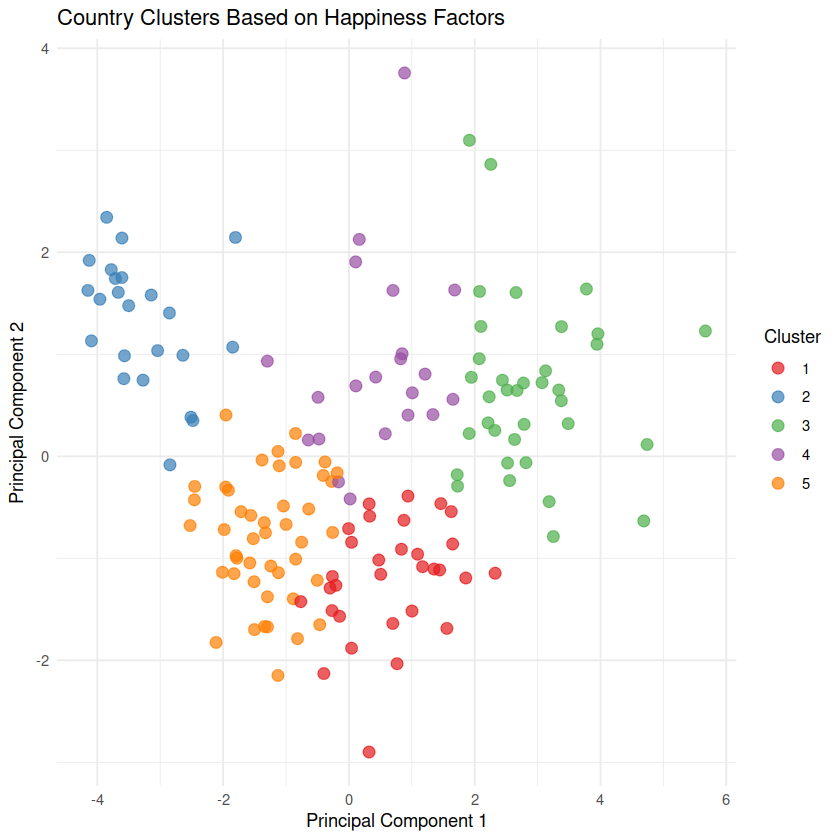

In [25]:
# Plot clusters in PCA space
ggplot(pca_df, aes(x = PC1, y = PC2, color = Cluster)) +
  geom_point(size = 3, alpha = 0.7) +
  scale_color_brewer(palette = "Set1") +
  labs(title = "Country Clusters Based on Happiness Factors",
       x = "Principal Component 1",
       y = "Principal Component 2") +
  theme_minimal()

In [26]:
# Prepare data for parallel coordinates plot
cluster_means <- happiness %>%
  group_by(Cluster) %>%
  summarise(across(where(is.numeric), mean))


In [27]:
cluster_means_long <- cluster_means %>%
  pivot_longer(cols = -Cluster, names_to = "Feature", values_to = "Mean_Value")


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


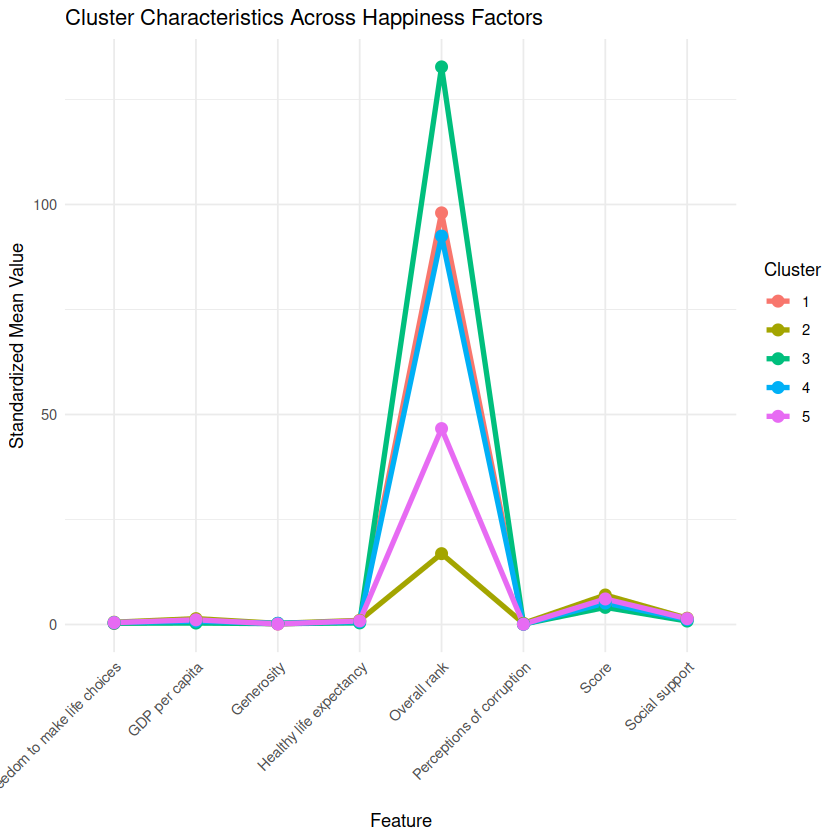

In [28]:

ggplot(cluster_means_long, aes(x = Feature, y = Mean_Value, group = Cluster, color = Cluster)) +
  geom_line(size = 1.5) +
  geom_point(size = 3) +
  labs(title = "Cluster Characteristics Across Happiness Factors",
       y = "Standardized Mean Value") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [29]:
# Calculate and display cluster characteristics
cluster_profiles <- happiness %>%
  group_by(Cluster) %>%
  summarise(
    Count = n(),
    Avg_GDP = mean(`GDP per capita`, na.rm = TRUE),
    Avg_Social = mean(`Social support`, na.rm = TRUE),
    Avg_Health = mean(`Healthy life expectancy`, na.rm = TRUE),
    Avg_Freedom = mean(`Freedom to make life choices`, na.rm = TRUE),
    Avg_Generosity = mean(Generosity, na.rm = TRUE),
    Avg_Corruption = mean(`Perceptions of corruption`, na.rm = TRUE)
  )


In [30]:

# Print cluster profiles
print(cluster_profiles)

# A tibble: 5 × 8
  Cluster Count Avg_GDP Avg_Social Avg_Health Avg_Freedom Avg_Generosity
  <fct>   <int>   <dbl>      <dbl>      <dbl>       <dbl>          <dbl>
1 1          31   0.968      1.20       0.759       0.259          0.106
2 2          23   1.40       1.49       0.990       0.548          0.275
3 3          36   0.351      0.824      0.387       0.301          0.203
4 4          21   0.771      1.17       0.661       0.457          0.290
5 5          45   1.12       1.39       0.867       0.449          0.130
# ℹ 1 more variable: Avg_Corruption <dbl>


In [31]:
cluster_profiles_long <- cluster_profiles %>%
  select(-Count) %>%
  pivot_longer(cols = -Cluster, names_to = "Feature", values_to = "Mean_Value")


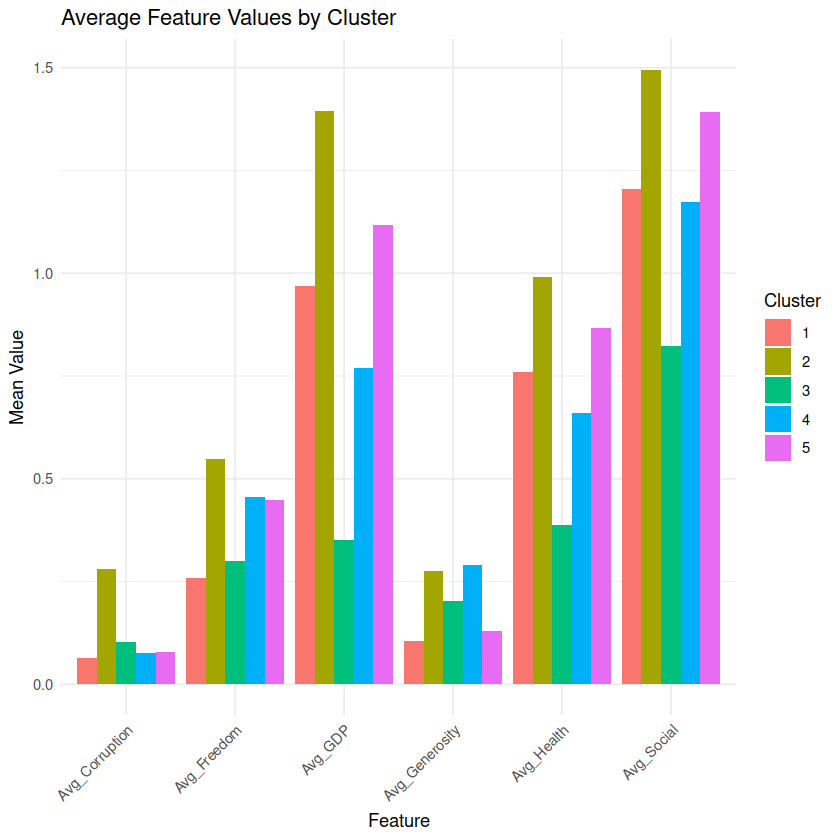

In [32]:
ggplot(cluster_profiles_long, aes(x = Feature, y = Mean_Value, fill = as.factor(Cluster))) +
  geom_col(position = "dodge") +
  labs(title = "Average Feature Values by Cluster",
       y = "Mean Value",
       fill = "Cluster") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))